# Tutorial: Advection Equation with data driven DeepONet neural operator

In this tutorial we will show how to solve the advection neural operator problem using `DeepONet`. Specifically, we will follow the original formulation of Lu Lu, et al. in [*DeepONet: Learning nonlinear operators for identifying differential equations based on the universal approximation theorem of operator*](https://arxiv.org/abs/1910.03193).

We import the relevant modules first.

In [1]:
import matplotlib.pyplot as plt
from pina import Trainer, Condition
from pina.model import FeedForward, DeepONet
from pina.solvers import SupervisedSolver
from pina.problem import AbstractProblem
from pina.loss import LpLoss
import torch

## The advection mathematical problem and data loading

Consider the one dimensional advection problem:
$$
\frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} = 0, \quad x\in[0,2], \;t\in[0,1]
$$
with periodic boundary condition. We choose the initial condition as a Gaussian wave centered in
$\mu$ and of width $\sigma^2=0.02$. We choose $\mu$ to be distributed according to a Uniform distribution in $[0.05, 1]$. Hence the initial condition is:
$$
u_0(x) = \frac{1}{\sqrt{\pi\sigma^2}}e^{-\frac{(x - \mu)^2}{2\sigma^2}}, \quad \mu\sim U(0.05, 1), \; x\in[0,2].
$$

The final objective is to learn the operator:

$$\mathcal{G} : u_0(x) → u(x, t = \delta) = u_0(x - \delta)$$

where we set $\delta=0.5$ just for sake of the tutorial. Notice that a general problem is to lear the operator mapping the initial condition to a specific time instance. By fixing $\delta$ dataset is composed of trajectories containing initial conditions as input, and the same trajectories after $\delta$ time as output. 

The input/output shape will be `[T, Nx, D]`, where `T` is the number of trajectories, `Nx` the discretization along the spatial dimension, and `D` the dimension of the input. In this case `D=1` since the input is the one dimensional field value `u`. The data for training are stored in `advection_input_training.pt`, `advection_output_training.pt`; while the one for testing in `advection_input_testing.pt`, `advection_output_testing.pt`. We train on `T=100` trajectories, and test on `T=1000`. Notice that the discretization in the spatial dimension is fixed to `Nx=100`.

We start by loading the data and perform some plotting.

In [2]:
# loading training data
data_0_training = torch.load('advection_input_training.pt')
data_dt_training = torch.load('advection_output_training.pt')

# loading testing data
data_0_testing = torch.load('advection_input_testing.pt')
data_dt_testing = torch.load('advection_output_testing.pt')

The data are loaded, let's visualize a few of the initial conditions!

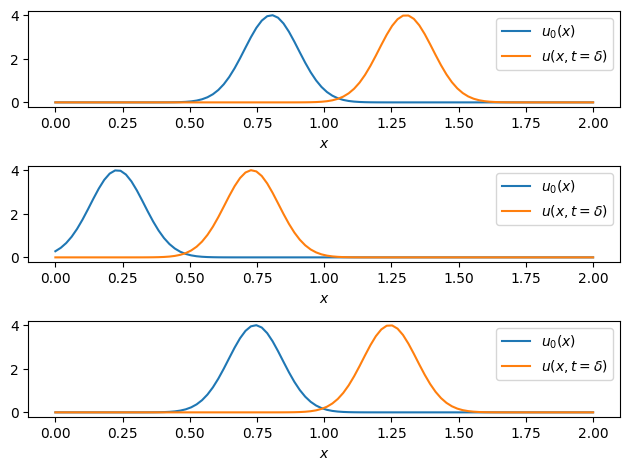

In [3]:
# storing the discretization in space:
Nx = data_0_training.shape[1]

for idx, i in enumerate(torch.randint(0, data_0_training.shape[0], (3,))):
    u0 = data_0_training[i].extract('ui')
    u = data_dt_training[i].extract('u')
    x = torch.linspace(0, 2, Nx) # the discretization in the spatial dimension is fixed
    plt.subplot(3, 1, idx+1)
    plt.plot(x, u0.flatten(), label=fr'$u_0(x)$')
    plt.plot(x, u.flatten(), label=fr'$u(x, t=\delta)$')
    plt.xlabel(fr'$x$')
    plt.tight_layout()
    plt.legend()

Great! We have created a travellig wave and we have visualized few examples. Now we are going to use the data to train the network.

## DeepONet
The classical formulation of DeepONet has two networks, namely **trunck** and **branch** net (see below figure).

<center>
<img src="./deeponet.png" alt="image from: Moya, C.; Lin, G. Fed-DeepONet: Stochastic Gradient-Based Federated Training of Deep Operator Networks. Algorithms 2022, 15, 325. https://doi.org/10.3390/a15090325" style="height: 280px; width:400px;"/>
</center>
<center>
<i>
Image from: Moya, C.; Lin, G. Fed-DeepONet: Stochastic Gradient-Based Federated Training of Deep Operator Networks. Algorithms 2022, 15, 325.
</i>
</center>

In our example the branch net will take as input a vector `[B, Nx]` representing for each trajectory the field solution at time zero discretize by `Nx`. The trunk net will take as input `[B, 1]` representing the temporal coordinate to evaluate the network. Here `B` is the number of training samples in a batch of the total trajectories.

Let us now write the advection problem.


In [4]:
class AdvectionProblem(AbstractProblem):

    output_variables = ['u']
    input_variables = ['ui']

    # problem condition statement
    conditions = {
        'data': Condition(input_points = data_0_training, output_points = data_dt_training)
    }

Notice that the problem inherits from `AbstractProblem`, since we only train our model in a datadriven mode.

We now proceede to create the trunk and branch networks.

In [5]:
# create Trunck model
class TrunkNet(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.trunk = FeedForward(**kwargs)
    def forward(self, x):
        t = torch.zeros(size=(x.shape[0], 1), requires_grad=False) + 0.5  # create an input of only 0.5
        return self.trunk(t)

# create Branch model
class BranchNet(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.branch = FeedForward(**kwargs)
    def forward(self, x):
        return self.branch(x.flatten(-2)) 

The `TrunckNet` is a simple `FeedForward` neural network with a modified `forward` pass. In the forward pass we simply create a tensor of $0.5$ repeated for each trajectory.

The `BranchNet` is a simple `FeedForward` neural network with a modified `forward` pass as well. The input is flatten across the last dimension to obtain a vector of the same dimension as the discretization, which represents the initial condition at the sensor points.

We now proceed to create the DeepONet model using the `DeepONet` class from `pina.model`

In [6]:
# initialize truck and branch net
trunk = TrunkNet(
    layers=[256] * 4,
    output_dimensions=Nx, # output the spatial discretization, must be equal to the one of branch net 
    input_dimensions=1,   # time variable
    func=torch.nn.ReLU
)
branch = BranchNet(
    layers=[256] * 4,
    output_dimensions=Nx, # output the spatial discretization, must be equal to the one of trunck net 
    input_dimensions=Nx,  # spatial discretization (supposing) data is alligned
    func=torch.nn.ReLU
)

# initialize the DeepONet model
model = DeepONet(branch_net=branch,
                trunk_net=trunk,
                input_indeces_branch_net=['ui'],
                input_indeces_trunk_net=['ui'],
                reduction = lambda x : x, 
                aggregator = lambda x : torch.einsum('bm,bm->bm', x[0], x[1])
                )

The aggregation + reduction functions combine the output of the two networks. In this case the output of the networks ar multiplied element wise and the corresponding vector is not reduced (i.e. we obtain as output the same as the trunck and branch output).

The solver, as in the [FNO tutorial](https://mathlab.github.io/PINA/_rst/tutorials/tutorial5/tutorial.html), is simply a `SupervisedSolver` trained with `MSE` loss. In the next lines we define the solver first, and then we define the trainer which is used for training the solver. 

The neural network training as been shown to better converge if some tricks are applied during training. As an example, we will use batch training with batch accumulation; and gradient clipping of the norm (acting as regularizer to prevent overfitting). Thanks to the [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) API, this complex techniques are achieved by only changing some flags in the Trainer. Notice that we do not hypersearch the best values, and we do this optimizations just for demonstration.

In [7]:
# define solver 
solver = SupervisedSolver(problem=AdvectionProblem(), model=model)

# define the trainer and train
# we train on cpu -> accelerator='cpu'
# we do not display model summary -> enable_model_summary=False
# we train for 100 epochs -> max_epochs=100
# we use batch size 5 -> batch_size=5
# we accumulate the gradient accross 20 batches -> accumulate_grad_batches=20
# we clip the gradient norm to a max of 1 -> gradient_clip_algorithm='norm', gradient_clip_val=1
trainer = Trainer(solver=solver, max_epochs=500, enable_model_summary=False,
                  accelerator='cpu', accumulate_grad_batches=20, batch_size=5,
                  gradient_clip_algorithm='norm', gradient_clip_val=1)
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dariocoscia/anaconda3/envs/pina/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343673238/work/aten/src/ATen/native/TensorShape.cpp:3575.)
  ret = func(*args, **kwargs)


Epoch 499: : 20it [00:00, 364.36it/s, v_num=31, mean_loss=3.09e-5] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: : 20it [00:00, 318.64it/s, v_num=31, mean_loss=3.09e-5]


Let us see the final train and test errors:

In [8]:
# the l2 error
l2 = LpLoss()

with torch.no_grad():
    train_err = l2(trainer.solver.neural_net(data_0_training), data_dt_training)
    test_err = l2(trainer.solver.neural_net(data_0_testing), data_dt_testing)

print(f'Training error: {float(train_err.mean()):.2%}')
print(f'Tresting error: {float(test_err.mean()):.2%}')

Training error: 0.39%
Tresting error: 1.03%


We can see that the testing error is slightly higher than the training one, maybe due to overfitting. We now plot some results trajectories.

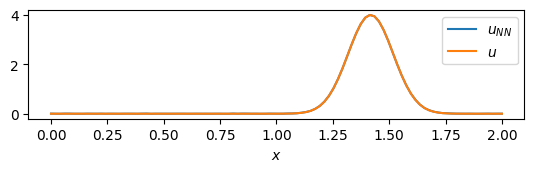

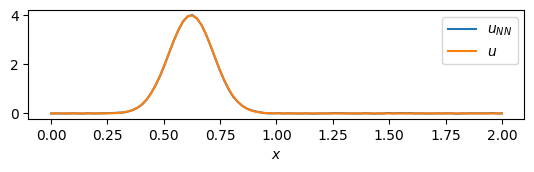

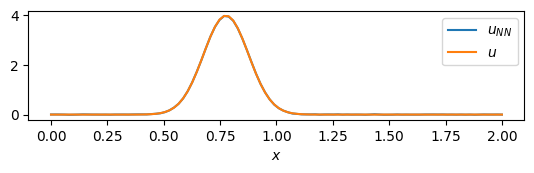

In [9]:
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.plot(torch.linspace(0, 2, Nx), solver.neural_net(data_0_training)[10*i].detach().flatten(), label=r'$u_{NN}$')
    plt.plot(torch.linspace(0, 2, Nx), data_dt_training[10*i].extract('u').flatten(), label=r'$u$')
    plt.xlabel(r'$x$')
    plt.legend(loc='upper right')
    plt.show()

As we can see, they are barely indistinguishable. To better understand the difference, we now plot the residuals, i.e. the difference of the exact solution and the predicted one. 

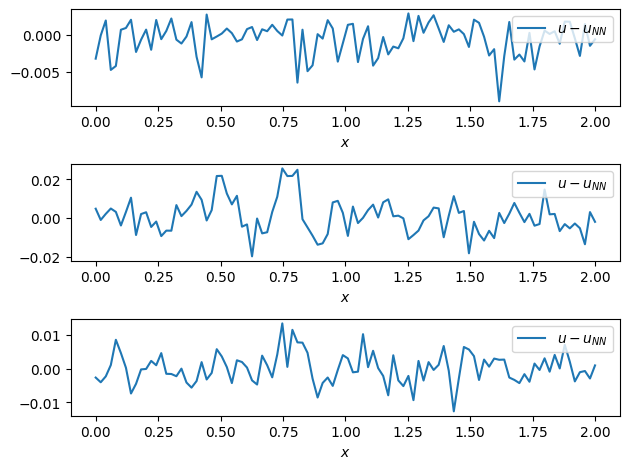

In [10]:
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.plot(torch.linspace(0, 2, Nx), data_dt_training[10*i].extract('u').flatten() - solver.neural_net(data_0_training)[10*i].detach().flatten(), label=r'$u - u_{NN}$')
    plt.xlabel(r'$x$')
    plt.tight_layout()
    plt.legend(loc='upper right')

## What's next?

We have made a very simple example on how to use the `DeepONet` for learning the advection neural operator. We suggest to extend the tutorial using more complex problems and train for longer, to see the full potential of neural operators. Another possible extension of the tutorial is to train the network to be able to learn the general operator, $\mathcal{G}_t : u_0(x) → u(x, t) = u_0(x - t)$.